In [1]:
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 로지스틱 회귀
from statsmodels.api import Logit
# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 그래프 한글폰트 적용:맑은 고딕
matplotlib.rc("font", family = "NanumGothic")
# 그래프 (-) 기호 표시
matplotlib.rc("axes", unicode_minus = False)

In [4]:
import os
os.getcwd()

'/home/piai/prac'

## 탄소강(C) 데이터

# step1. 데이터 불러오기 및 구성하기

In [5]:
df_c = pd.read_csv("/home/piai/prac/02/plate_c.csv")
df_c.head()

,scale,steel_kind,hsb,fur_avg_temp,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,양품,C,적용,1127.5,297,CR(제어압연),934,8,2조
1,양품,C,적용,1136.0,235,CR(제어압연),911,8,2조
2,양품,C,적용,1130.0,240,CR(제어압연),935,10,2조
3,양품,C,적용,1130.0,287,CR(제어압연),935,10,2조
4,양품,C,적용,1135.5,286,CR(제어압연),915,10,2조


In [6]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            753 non-null    object 
 1   steel_kind       753 non-null    object 
 2   hsb              753 non-null    object 
 3   fur_avg_temp     753 non-null    float64
 4   fur_total_time   753 non-null    int64  
 5   rolling_method   753 non-null    object 
 6   rolling_temp     753 non-null    int64  
 7   descaling_count  753 non-null    int64  
 8   work_group       753 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 53.1+ KB


In [7]:
obj_cols = df_c.select_dtypes("object").columns

for col in obj_cols:
    _n = len(df_c[col].value_counts())
    print(col, ":", str(_n))

scale : 2
steel_kind : 1
hsb : 2
rolling_method : 1
work_group : 4


+ 명목형 변수를 확인 -> C를 통해 범주형 변수 표시.

# step2. 데이터 전처리

In [8]:
# 목표변수 y : 양품 (1) , 불량 (0)

# 1. 'scale' 열을 더미화
df_dummies = pd.get_dummies(df_c['scale'], prefix='scale', drop_first=True)

# 2. 더미화된 열의 이름을 "scale"로 변경
df_dummies.columns = ['scale']

# 3. 더미화된 결과를 원래 데이터프레임에 병합하고 맨 앞열로 이동
df_c = pd.concat([df_dummies, df_c.drop('scale', axis=1)], axis=1)

+ 목표변수는 scale/ 양품 : 1 , 불량 : 0
+ scale을 더미화

In [9]:
df_c.head()

,scale,steel_kind,hsb,fur_avg_temp,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,1,C,적용,1127.5,297,CR(제어압연),934,8,2조
1,1,C,적용,1136.0,235,CR(제어압연),911,8,2조
2,1,C,적용,1130.0,240,CR(제어압연),935,10,2조
3,1,C,적용,1130.0,287,CR(제어압연),935,10,2조
4,1,C,적용,1135.5,286,CR(제어압연),915,10,2조


In [10]:
df_c.drop('steel_kind', axis=1, inplace=True)

+ steel_kind는 1차 층별화를 했으므로 제거

In [13]:
# train_test_split(데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train, df_test = train_test_split(df_c, # 데이터
                                     test_size = 0.3, # test 데이터의 비율
                                     random_state = 1234)  # random state

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (527, 8)
test data size : (226, 8)


+ 데이터를 7:3으로 분할

# step3. 모델 및 회귀계수 검토

### 1. 모든 설명변수 포함

In [14]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + fur_total_time + rolling_temp + C(hsb) + C(rolling_method) + C(work_group) + C(descaling_count)""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.232547
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      515
Method:                           MLE   Df Model:                           11
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.6525
Time:                        23:33:07   Log-Likelihood:                -122.55
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 9.827e-92
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  150.5419   5782.173      0.026      0.979   -1.12e+04    1.15e+04
C(hsb)[T.적용]           

###  2. descaling count 제거

In [15]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + fur_total_time + rolling_temp + C(hsb) + C(rolling_method) + C(work_group)""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.389683
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.4176
Time:                        23:33:10   Log-Likelihood:                -205.36
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 8.805e-60
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.8085   1.26e+04      0.006      0.995   -2.46e+04    2.48e+04
C(hsb)[T.적용]           26.7153   1.26e

#### 2-1 descaling count + work group 제거

In [16]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + fur_total_time + rolling_temp + C(hsb) + C(rolling_method) """, df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.399800
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      522
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.4025
Time:                        23:33:11   Log-Likelihood:                -210.69
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 3.231e-60
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         65.9275   2.73e+04      0.002      0.998   -5.34e+04    5.35e+04
C(hsb)[T.적용]      27.8053   2.73e+04      0.001      

### 3. work group 제거

In [17]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + fur_total_time + rolling_temp + C(hsb) + C(rolling_method)  + C(descaling_count)""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.242656
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      518
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.6374
Time:                        23:33:11   Log-Likelihood:                -127.88
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 4.687e-92
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  135.2280   1.87e+04      0.007      0.994   -3.66e+04    3.68e+04
C(hsb)[T.적용]           

### 4. fur total time 제거

In [18]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + rolling_temp + C(hsb) + /
                                    C(rolling_method) + C(work_group) + C(descaling_count)""", df_train)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

         Current function value: 0.235163
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      516
Method:                           MLE   Df Model:                           10
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.6486
Time:                        23:33:12   Log-Likelihood:                -123.93
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 5.465e-92
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  142.9639   6004.621      0.024      0.981   -1.16e+04    1.19e+04
C(hsb)[T.적용]           

## 최종모델 선정

In [28]:
log_model = Logit.from_formula("""scale ~ fur_avg_temp + rolling_temp + C(hsb) + C(rolling_method) /
                                    + C(work_group) + C(descaling_count)""", df_train)
log_result = log_model.fit()
print(log_result.summary())

         Current function value: 0.235163
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      516
Method:                           MLE   Df Model:                           10
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.6486
Time:                        23:37:50   Log-Likelihood:                -123.93
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 5.465e-92
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         142.7352   6478.285 

+ 후진소거법에 의해서 최종모델 선정

+ descaling이 scale을 지워주기 때문에 중요한 변수라고 생각했다.
+ 반면 fur_total_time은 중요변수라고 생각되지 않아서 제거했다.

+ 1. 전체 자료수 : 527 , 잔차 자유도 : 516 , 모델 자유도 : 10
+ 2. 설명력 : 0.6486
+ 3. 회귀계수 유의성 검정 : descaling_count를 제외한 모든 변수가 유의 변수 

# step4. 예측 및 성능 평가

In [31]:
# train 데이터 예측
y_pred_train = log_result.predict(df_train)
# 0과 1의 값을 가진 class로 변환
y_pred_train_class = (y_pred_train > 0.5).astype(int)  # 0.5 : “1/0” 판정 임계값(1 발생 확률) 변경 가능 
print("Train 예측 결과 \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")

# test 데이터 예측
y_pred_test = log_result.predict(df_test)
# 0과 1의 값을 가진 class로 변환
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과 \n", y_pred_test_class.head(),"\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")

Train 예측 결과 
 328    1
173    0
171    1
624    1
577    1
dtype: int64 

Confusion Matrix: 
[[177  29]
 [ 28 293]] 

Test 예측 결과 
 680    1
353    1
623    1
519    1
156    0
dtype: int64 

Confusion Matrix: 
[[ 69  15]
 [ 12 130]] 



In [32]:
# 실제 train 데이터와 예측 결과 비교
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["scale"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")
print(classification_report(df_train["scale"], y_pred_train_class, digits=3))

# 실제 train 데이터와 예측 결과 비교
print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["scale"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")
print(classification_report(df_test["scale"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.892

Confusion Matrix: 
[[177  29]
 [ 28 293]] 

              precision    recall  f1-score   support

           0      0.863     0.859     0.861       206
           1      0.910     0.913     0.911       321

    accuracy                          0.892       527
   macro avg      0.887     0.886     0.886       527
weighted avg      0.892     0.892     0.892       527

Test 예측/분류 결과
Accuracy: 0.881

Confusion Matrix: 
[[ 69  15]
 [ 12 130]] 

              precision    recall  f1-score   support

           0      0.852     0.821     0.836        84
           1      0.897     0.915     0.906       142

    accuracy                          0.881       226
   macro avg      0.874     0.868     0.871       226
weighted avg      0.880     0.881     0.880       226



+ 1. 모델의 Test데이터 정분류율은 88.1% , Train데이터의 정분류율은 89.2%로 overfitting 없음
     성능이 좋은 편인 것 같다.
+ 2. 분류 내용
    -> 실제 0을 0으로 분류 177건
    -> 실제 1을 0으로 분류 28건
    -> 실제 1을 1으로 분류 293건
    -> 실제 0을 1으로 분류 29건
+ 3. '1'기준 f1 score는 91.1%
      (precision , recall 모두 높다.)

# step5. 결론 도출 - 최종 회귀식

In [37]:
# logit(P(scale = 1)) = 142.7352 
#     + 30.0902 × C(hsb)[T.적용] − 12.1613 × C(descaling_count)[T.7] + 16.3886 × C(descaling_count)[T.8] 
#     − 23.0647 × C(descaling_count)[T.9] + 16.5990 × C(descaling_count)[T.10] 
#     + 0.2322 × C(rolling_method)[CR(제어압연)]:C(work_group)[T.2조] 
#     + 1.3431 × C(rolling_method)[CR(제어압연)]:C(work_group)[T.3조] 
#     + 0.4531 × C(rolling_method)[CR(제어압연)]:C(work_group)[T.4조] 
#     − 0.0910 × fur_avg_temp − 0.0844 × rolling_temp

In [41]:
df_scale = df_c.select_dtypes(include = "object")
df_numeric = df_c.select_dtypes(exclude = "object")

# Data Scaling
scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled = pd.concat([df_numeric_scaled, df_scale],axis = 1)
df_scaled.head()

,scale,fur_avg_temp,fur_total_time,rolling_temp,descaling_count,hsb,rolling_method,work_group
0,0.791423,-2.325197,1.901318,-0.638279,-1.140355,적용,CR(제어압연),2조
1,0.791423,-1.733509,0.153117,-1.115582,-1.140355,적용,CR(제어압연),2조
2,0.791423,-2.151171,0.294101,-0.617526,0.700347,적용,CR(제어압연),2조
3,0.791423,-2.151171,1.619350,-0.617526,0.700347,적용,CR(제어압연),2조
4,0.791423,-1.768314,1.591154,-1.032573,0.700347,적용,CR(제어압연),2조


In [42]:
# scale 데이터를 0과 1로 변환(정수형), np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["scale"] = np.where(df_scaled["scale"]> 0, 1, 0)
df_scaled.head()

,scale,fur_avg_temp,fur_total_time,rolling_temp,descaling_count,hsb,rolling_method,work_group
0,1,-2.325197,1.901318,-0.638279,-1.140355,적용,CR(제어압연),2조
1,1,-1.733509,0.153117,-1.115582,-1.140355,적용,CR(제어압연),2조
2,1,-2.151171,0.294101,-0.617526,0.700347,적용,CR(제어압연),2조
3,1,-2.151171,1.619350,-0.617526,0.700347,적용,CR(제어압연),2조
4,1,-1.768314,1.591154,-1.032573,0.700347,적용,CR(제어압연),2조


In [43]:
# 데이터 분할
df_scaled_train, df_scaled_test = train_test_split(df_scaled, # 데이터
                               test_size = 0.3, # test 데이터의 비율
                               random_state = 1234)  # random state

In [44]:
# from_formula 함수를 이용하여 변수 역할 지정

scaled_log_model = Logit.from_formula("""scale ~ fur_avg_temp + rolling_temp + C(hsb) + C(rolling_method) /
                                         + C(work_group) + C(descaling_count)""", df_scaled_train)

# 적합
scaled_log_result = scaled_log_model.fit()
# 결과 출력
print(scaled_log_result.summary())

         Current function value: 0.235163
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  527
Model:                          Logit   Df Residuals:                      516
Method:                           MLE   Df Model:                           10
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.6486
Time:                        00:09:19   Log-Likelihood:                -123.93
converged:                      False   LL-Null:                       -352.64
Covariance Type:            nonrobust   LLR p-value:                 5.465e-92
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         -41.9130   5728.191 

<Axes: >

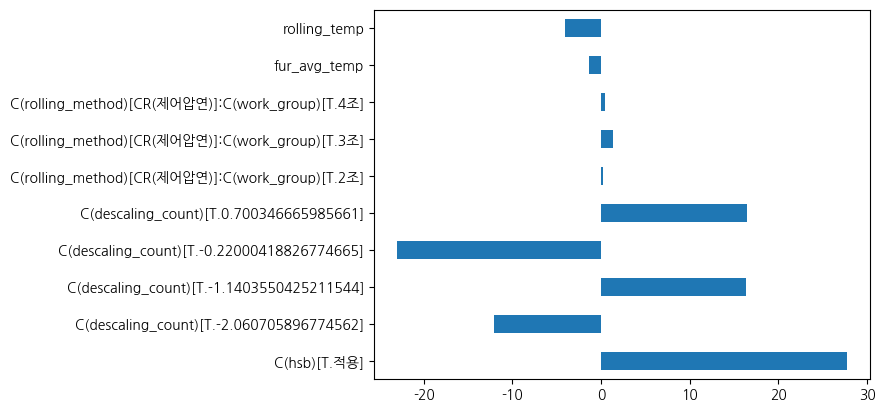

In [45]:
df_log_scaled_coef = pd.DataFrame({"Coef": scaled_log_result.params.values[1:]}, index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y = "Coef", legend = False)

+ 설명변수 중요도

+ 양품이 1이다.
+ hsb를 할수록 양품이 될 확률이 높아진다.

## 티타늄(Ti) 데이터

# step1. 데이터 불러오기 및 구성하기

In [5]:
df_t = pd.read_csv("/home/piai/prac/02/plate_t.csv")
df_t.head()

,scale,steel_kind,hsb,fur_avg_temp,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,양품,T,적용,1138.5,259,TMCP(온도제어),934,8,1조
1,양품,T,적용,1139.5,238,TMCP(온도제어),937,8,1조
2,양품,T,적용,1125.0,258,TMCP(온도제어),889,8,1조
3,양품,T,적용,1139.5,266,TMCP(온도제어),885,8,1조
4,양품,T,적용,1134.0,246,TMCP(온도제어),873,8,1조


In [6]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scale            241 non-null    object 
 1   steel_kind       241 non-null    object 
 2   hsb              241 non-null    object 
 3   fur_avg_temp     241 non-null    float64
 4   fur_total_time   241 non-null    int64  
 5   rolling_method   241 non-null    object 
 6   rolling_temp     241 non-null    int64  
 7   descaling_count  241 non-null    int64  
 8   work_group       241 non-null    object 
dtypes: float64(1), int64(3), object(5)
memory usage: 17.1+ KB


In [7]:
obj_cols = df_t.select_dtypes("object").columns

for col in obj_cols:
    _n = len(df_t[col].value_counts())
    print(col, ":", str(_n))

scale : 2
steel_kind : 1
hsb : 2
rolling_method : 2
work_group : 3


+ 명목형 변수를 확인 -> C를 통해 범주형 변수 표시.

# step2. 데이터 전처리

In [8]:
# 목표변수 y : 양품 (1) , 불량 (0)

# 1. 'scale' 열을 더미화
df_dummies = pd.get_dummies(df_t['scale'], prefix='scale', drop_first=True)

# 2. 더미화된 열의 이름을 "scale"로 변경
df_dummies.columns = ['scale']

# 3. 더미화된 결과를 원래 데이터프레임에 병합하고 맨 앞열로 이동
df_t = pd.concat([df_dummies, df_t.drop('scale', axis=1)], axis=1)

+ 목표변수는 scale/ 양품 : 1 , 불량 : 0
+ scale을 더미화

In [9]:
df_t.head()

,scale,steel_kind,hsb,fur_avg_temp,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,1,T,적용,1138.5,259,TMCP(온도제어),934,8,1조
1,1,T,적용,1139.5,238,TMCP(온도제어),937,8,1조
2,1,T,적용,1125.0,258,TMCP(온도제어),889,8,1조
3,1,T,적용,1139.5,266,TMCP(온도제어),885,8,1조
4,1,T,적용,1134.0,246,TMCP(온도제어),873,8,1조


In [10]:
df_t.drop('steel_kind', axis=1, inplace=True)

+ steel_kind는 1차 층별화를 했으므로 제거

# step3. 모델 및 회귀계수 검토

### 0. 다중공선성 제거

In [11]:
# 잔차의 정규성 확인 :qqplot, 회귀분석의 상수항 추가 : add_constant
from statsmodels.api import qqplot, add_constant
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
df_y = df_t['scale']
df = df_t.drop('scale', axis=1)
df['rolling_method'] = df['rolling_method'].str.replace('조', '')
df_dummies = pd.get_dummies(df, drop_first=True)

In [13]:
df_y.head()

0    1
1    1
2    1
3    1
4    1
Name: scale, dtype: uint8

In [14]:
df_dummies.head()

,fur_avg_temp,fur_total_time,rolling_temp,descaling_count,hsb_적용,rolling_method_TMCP(온도제어),work_group_2조,work_group_3조
0,1138.5,259,934,8,1,1,0,0
1,1139.5,238,937,8,1,1,0,0
2,1125.0,258,889,8,1,1,0,0
3,1139.5,266,885,8,1,1,0,0
4,1134.0,246,873,8,1,1,0,0


+ y인 'scale' 제거
+ 단위인 '조' 제거
+ 나머지 범주형 변수 더미화

<Axes: >

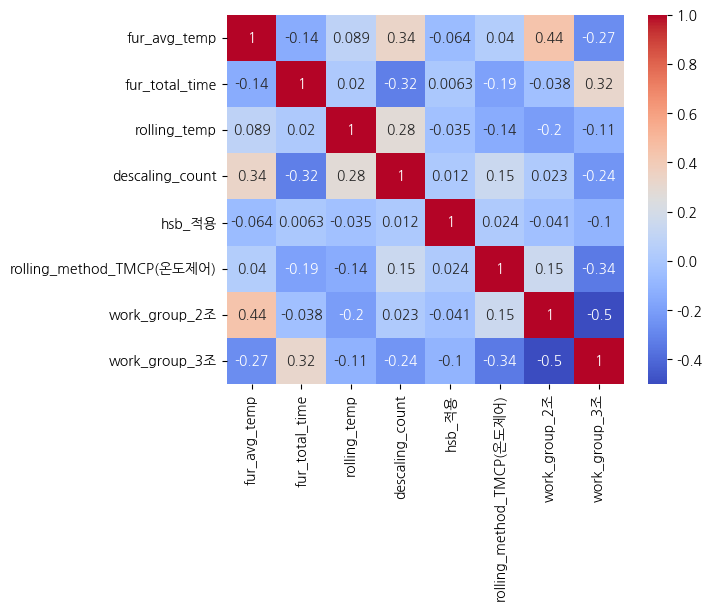

In [15]:
import seaborn as sns

corr_matrix = df_dummies.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

+ work_group의 2조와 3조 사이에 강한 상관관계가 존재
+ 3조에서 불량이 계속 나왔던 것이 있어서 2조를 제거
+ 하지만 2조를 제거해서는 모델이 돌아가지 않아서 3조를 제거하여 진행

In [16]:
df_dummies.drop('work_group_3조',axis=1,inplace=True)

In [17]:
df_dummies['scale'] = df_y

In [18]:
df_dummies.head()

,fur_avg_temp,fur_total_time,rolling_temp,descaling_count,hsb_적용,rolling_method_TMCP(온도제어),work_group_2조,scale
0,1138.5,259,934,8,1,1,0,1
1,1139.5,238,937,8,1,1,0,1
2,1125.0,258,889,8,1,1,0,1
3,1139.5,266,885,8,1,1,0,1
4,1134.0,246,873,8,1,1,0,1


In [19]:
df_dummies = df_dummies.rename(columns={'rolling_method_TMCP(온도제어)': 'rolling_method_TMCP'})

In [20]:
df_dummies.head()

,fur_avg_temp,fur_total_time,rolling_temp,descaling_count,hsb_적용,rolling_method_TMCP,work_group_2조,scale
0,1138.5,259,934,8,1,1,0,1
1,1139.5,238,937,8,1,1,0,1
2,1125.0,258,889,8,1,1,0,1
3,1139.5,266,885,8,1,1,0,1
4,1134.0,246,873,8,1,1,0,1


In [21]:
df_train, df_test = train_test_split(df_dummies, test_size = 0.3, random_state = 1234)
print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (168, 8)
test data size : (73, 8)


+ 데이터를 7:3으로 분할

### 1. 모든 설명변수 포함

In [22]:
# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""scale ~ fur_avg_temp + fur_total_time + rolling_temp + hsb_적용 + rolling_method_TMCP +work_group_2조""", df_train)
# 적합
log_result = log_model.fit()
# 결과 출력
print(log_result.summary())

         Current function value: 0.124688
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  168
Model:                          Logit   Df Residuals:                      161
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Aug 2024   Pseudo R-squ.:                  0.4474
Time:                        01:30:34   Log-Likelihood:                -20.948
converged:                      False   LL-Null:                       -37.910
Covariance Type:            nonrobust   LLR p-value:                 6.955e-06
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.7901   3.12e+04      0.000      1.000   -6.12e+04    6.12e+04
fur_avg_temp           -0.0160      0.

+ 모든 회귀계수가 유의하지 않아서 회귀분석은 적합하지 않는 모델이라고 판단됨